# <center> Project 2 - Classification of Wind Turbine Alarms </center>

## <center> MSDS 7331 Data Mining - Section 401 - Project 2 </center> 
### <center> Team:  Sarah Fite, Sheri Loftin, Casey Martinez, Kyle Thomas </center>




<a id="top"></a>
# Table of Contents
* <a href="#Imports and Data">Imports and Data</a>
    - Cleaning the Data
    - Merging the Data
    - Create New Variables
    - Reducing Dataset
* <a href="#Create Models">**Create Models</a>
     - Support Vector Machine (SVM) Model 
       - Visualizations
       - Classification of Turbine Performance
       - Support Vector Machine Preprocessing
       - Training and Test Data Creation (80/20 Split)
       - Model creation and Parameter Optimization With Grid Search
       - Results
       - **Interpret Support Vectors
     - Logistics Regression 
       - **Feature Importance 
       -  Reference Section
       -  Visualizations
* <a href="#Model Advantages">**Model Advantages</a>

"**" Denotes items from rubric

<a id="Imports and Data"></a>
# Imports and Data

For this project, we continue to examine data provided by Siemens, the wind turbine manufacturer, and Pattern Energy, the owner/operator (Casey Martinez's employer).  For this project we analyze this dataset using both Logistics Regression and Support Vector Machines (SVM).

The background of this data and the business understanding behind it can be found as part of Project 1 at: https://github.com/CaseyRMartinez/DataMiningProject1/blob/master/DataMiningProject1_V5.ipynb

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import sklearn
import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
%matplotlib inline
import pylab
from scipy.optimize import curve_fit
# from sklearn import svm
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.preprocessing import Imputer
# from sklearn import preprocessing
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics as mt
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.model_selection import ShuffleSplit
# from sklearn.model_selection import cross_val_score

# pd.show_versions()

To start, we will first look at the alarm data and one quarter worth of wind farm supervisory control and data acquisition (SCADA) system data.  This SCADA data is specifically used for performance monitoring of large utility-scale wind turbines.

In [2]:
# path = '~/Documents/thomaskh522@gmail.com/SMU/DataMining/MiniProject/Data/'
path = 'D:/Pattern/'
alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")
scada = pd.read_csv(path + "SCADAcombined2017_T014.csv")

# drop columns that were missing values
scada.dropna(thresh=10000,axis=1,inplace=True)

print('alarm description shape:',alarms_desc.shape)
print('scada data shape:',scada.shape)

alarm description shape: (2141, 3)
scada data shape: (52462, 689)


### Cleaning the Data

Next, we dropped missing values from our dataset, removed unused columns, and reduce the data set to only one turbine.

In [3]:
list(scada.columns)

['TimeStamp',
 'StationId',
 'wtc_VoltPhR_min',
 'wtc_VoltPhR_max',
 'wtc_VoltPhR_mean',
 'wtc_VoltPhR_stddev',
 'wtc_VoltPhS_min',
 'wtc_VoltPhS_max',
 'wtc_VoltPhS_mean',
 'wtc_VoltPhS_stddev',
 'wtc_VoltPhT_min',
 'wtc_VoltPhT_max',
 'wtc_VoltPhT_mean',
 'wtc_VoltPhT_stddev',
 'wtc_ActPower_min',
 'wtc_ActPower_max',
 'wtc_ActPower_mean',
 'wtc_ActPower_stddev',
 'wtc_AmpPhR_min',
 'wtc_AmpPhR_max',
 'wtc_AmpPhR_mean',
 'wtc_AmpPhR_stddev',
 'wtc_AmpPhS_min',
 'wtc_AmpPhS_max',
 'wtc_AmpPhS_mean',
 'wtc_AmpPhS_stddev',
 'wtc_AmpPhT_min',
 'wtc_AmpPhT_max',
 'wtc_AmpPhT_mean',
 'wtc_AmpPhT_stddev',
 'wtc_CosPhi_min',
 'wtc_CosPhi_max',
 'wtc_CosPhi_mean',
 'wtc_CosPhi_stddev',
 'wtc_GridFreq_min',
 'wtc_GridFreq_max',
 'wtc_GridFreq_mean',
 'wtc_GridFreq_stddev',
 'wtc_ReactPwr_min',
 'wtc_ReactPwr_max',
 'wtc_ReactPwr_mean',
 'wtc_ReactPwr_stddev',
 'wtc_ActRegSt_endvalue',
 'wtc_RawPower_min',
 'wtc_RawPower_max',
 'wtc_RawPower_mean',
 'wtc_RawPower_stddev',
 'TimeStamp.1',
 'Stat

In [4]:
cols = ['TimeStamp','Name', 'StationId', 'wtc_ActPower_mean', 'wtc_ActPower_stddev','wtc_AlarmCde_endvalue',
       'wtc_YawPos_mean','wtc_BoostAva_mean','wtc_PowerRef_endvalue','WS_Thies_80m_Avg','WS_Thies_26m_Avg',
       'wtc_ScInOper_timeon','AirTC_3m_Avg','WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'WindDir_ICEFREE_D1_WVT',
        'wtc_AcWindSp_stddev','wtc_AcWindSp_mean','WS_Thies_80m_Std']

scada2 = scada[cols]

print('scada data shape:',scada2.shape)

#scada.isnull().sum()

scada data shape: (52462, 19)


### Merging the Data

After cleaning the data, we merged the alarm data with the SCADA Q1 data in order to conduct logistics regression and SVM prediciton. The following shows the shape of the data after merge.

In [5]:
# merge the alarms with the alarm descriptions

scada2.dropna(inplace=True)
scada2['wtc_AlarmCde_endvalue'] = scada2['wtc_AlarmCde_endvalue'].astype(int)

df = scada2.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index

df.dropna(inplace=True)

print(df.shape)
# df.describe().transpose()

(52756, 21)


C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Create New Variables

We know through independent research and analysis that certain calculated values would strengthen our model, but are not present in our current dataset. Thus, we chose to calculate, create, and add these values to our merged data set.  The variables are:
- WindSpeed_adj - variable created for grouping purposes
- Fault_Type- renamed existing "Fault Type" column to "Fault_Type" and recodes it as an integer
- Derated - derating is operating a device at less than its optimal capacity in order to prolong its life.  Derating is commonly used on windfarms to prolong the life of a turbine.
- Available- reflects whether or not a turbine is available based on faults and if it's powered on.
- Air Density- calculates and stores air density values
- Hour of Day- adjusted wind speed to reflect nighttime changes
- Boosted Ref- adding a boost for the reference set point
- Wind Sheer- variation in wind velocity occurring at right angles to the wind's direction and tending to exert a turning force.
- Boosted Power Delta- The boosted ref minus the mean
- Icing- mathematical calculation to account for ice on the turbine
- Air Density Adjusted Wind Speed- mathematical calculation to account for air density and windspeed on turbine performance
- Turbulence- mathematical calculation to account for turbulence on turbine performance
- Expected Energy- Calculation to reflect the Power Curve impact on the Wind Speed mean
- Expected Energy25th- Calculation to reflect the 25th percentile Power Curve impact on the Wind Speed mean
- Expected Energy Median-Calculation to reflect the median percentile Power Curve impact on the Wind Speed mean 
- Underperformance- variable created to store whether turbine is underperforming

In [6]:
# Create new variables

# Rounded Wind Speed for GroupBy
df['WindSpeed_adj'] = df['wtc_AcWindSp_mean'].round(1)

# Wind changes at night
df['HourOfDay'] = df.index.hour

# Yaw Error
df['YawError'] = df['wtc_YawPos_mean'] - df['WindDir_ICEFREE_D1_WVT']

# Adding boost to ref set point
df['BoostedRef'] = df['wtc_BoostAva_mean'] + df['wtc_PowerRef_endvalue']

# Wind Sheer
df['WindSheer1'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_26m_Avg']) / np.log(80/26)
# df['WindSheer2'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_60m_Avg']) / np.log(80/60)

# Fault Types
df = df.rename(columns={'Fault Type': 'Fault_Type'})
df['Fault_Type'] = df['Fault_Type'].replace('W','0')
df['Fault_Type'] = df['Fault_Type'].astype(int)

# Boosted Power Delta
df['PowerDelta'] = df['BoostedRef'] - df['wtc_ActPower_mean']

available = (df['Fault_Type'] != 1) & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

# Icing
icing = (df['AirTC_3m_Avg'] < 3) & (abs(df['WS_ICEFREE_Avg'] - df['WS_Thies_80m_Avg']) > 1)
df['Icing'] = [1 if x == True else 0 for x in icing]

# Air Density
df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# Air Density adjusted Wind Speed
df['AdjTurbineWS'] = df['wtc_AcWindSp_mean']*(np.power(df['Air_density'],(1/3)))

# Turbulence
df['TurbulenceMet'] = df['WS_Thies_80m_Std'] / df['WS_Thies_80m_Avg']
df['TurbulenceTurbine'] = df['wtc_AcWindSp_stddev'] / df['wtc_AcWindSp_mean']

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

df.dropna(inplace=True)

C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


#### Turbine Derate Conditions

It is difficult to know which of the reference set point conditions actually limit the performance of the turbine. We need to categorize these conditions to remove them from our data set when fitting a curve matching the "good" performance data.

In [7]:
# Calculating Derate Conditions

#derate = (df['wtc_ActPower_mean'] == df['wtc_PowerRef_endvalue']) & (df['wtc_PowerRef_endvalue'] < 2300)
#derate = (df['wtc_PowerRef_endvalue'] < 2300)
derate = (df['PowerDelta'] < 0) & (df['Available'] == 1) & (df['BoostedRef'] < 2300) #df['BoostedRef'].max())
df['Derated'] = [1 if x == True else 0 for x in derate]

percent = (df['Derated'].sum() / len(df))*100
print('Percent of Derated Data:',percent,"%")

Percent of Derated Data: 9.90129196997 %


#### Cleaned Power Curve

This subset of data consists of all performance that is not attributed to faults, derates, icing, or boosting. This data is where we curve fit to create our expected energy. We will then calculate expected energy on the original data frame for classification.

In [8]:
# Use cleaned data set for calculating expected energy
clean = (df['Available'] == 1) & (df['wtc_PowerRef_endvalue'] == 2300) & (df['Icing'] == 0) & (df['wtc_BoostAva_mean'] == 0)
df_clean = df[clean]

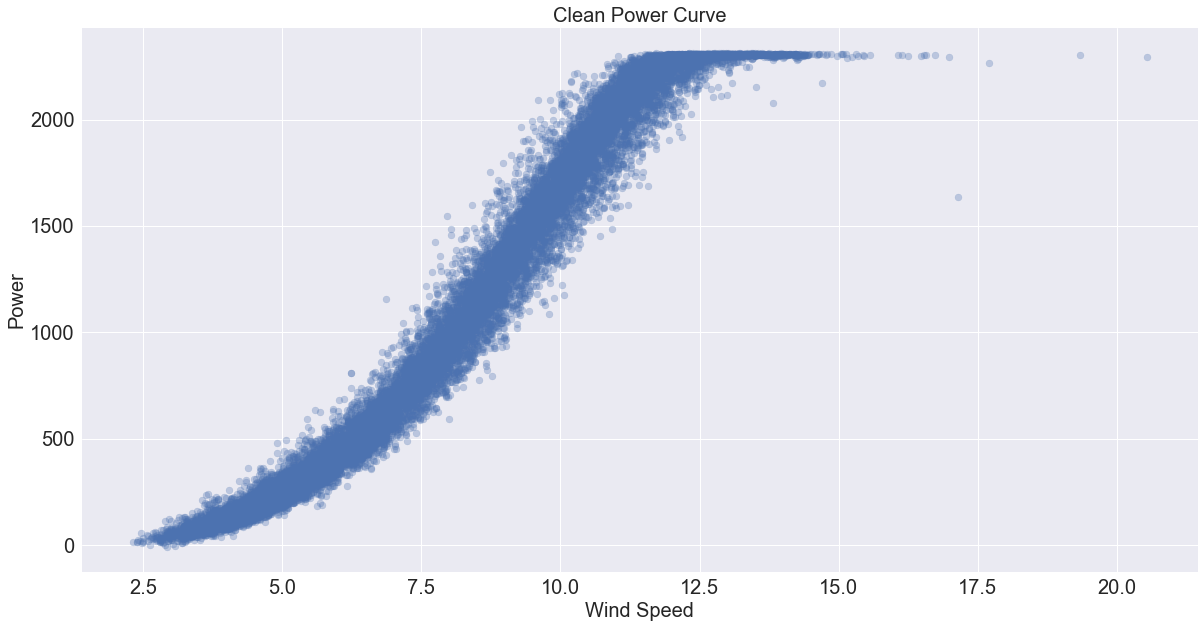

In [9]:

x2 = df_clean['wtc_AcWindSp_mean']
y2 = df_clean['wtc_ActPower_mean'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.scatter(x2, y2,alpha=0.3)#, c=c)

plt.title("Clean Power Curve")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
# plt.legend()
plt.show()

### Plotting Historical Quantiles from Clean Power Curve

In [10]:
pcurve95 = df_clean.groupby('WindSpeed_adj').quantile(q=0.95)
pcurve75 = df_clean.groupby('WindSpeed_adj').quantile(q=0.75)
pcurve50 = df_clean.groupby('WindSpeed_adj').median()
pcurve25 = df_clean.groupby('WindSpeed_adj').quantile(q=0.25)
pcurve5 = df_clean.groupby('WindSpeed_adj').quantile(q=0.05)

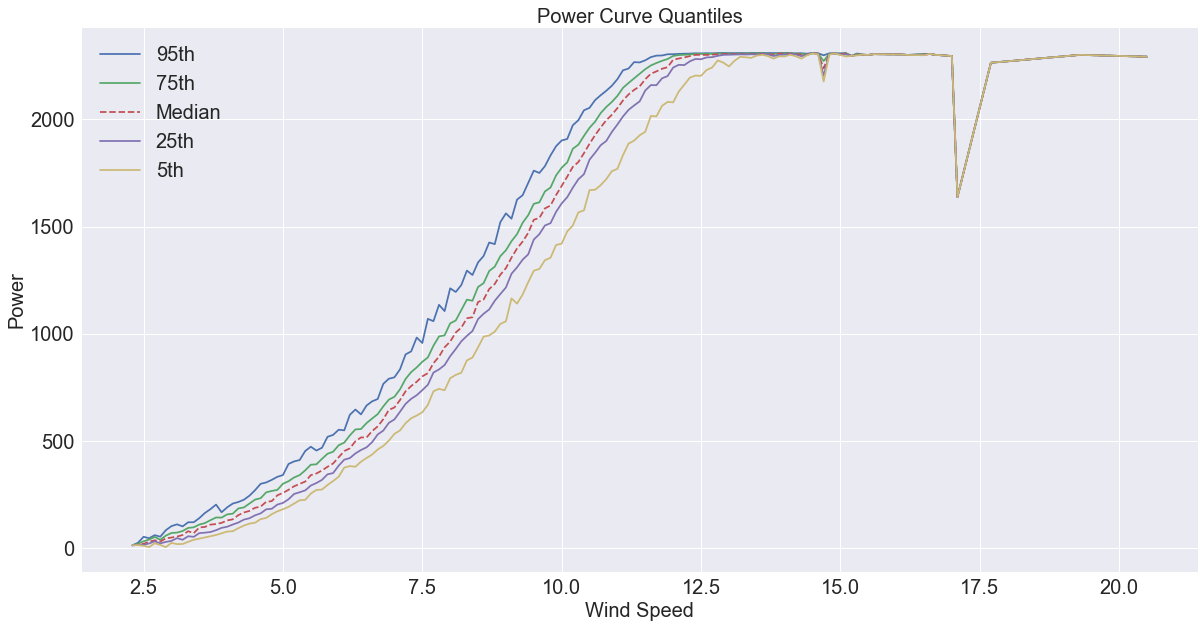

In [11]:
x1 = pcurve95.index.values
y1 = pcurve95['wtc_ActPower_mean'] 

x2 = pcurve75.index.values
y2 = pcurve75['wtc_ActPower_mean'] 

x3 = pcurve50.index.values
y3 = pcurve50['wtc_ActPower_mean'] 

x4 = pcurve25.index.values
y4 = pcurve25['wtc_ActPower_mean'] 

x5 = pcurve5.index.values
y5 = pcurve5['wtc_ActPower_mean'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.plot(x1, y1, label='95th')
plt.plot(x2, y2, label='75th')
plt.plot(x3, y3, linestyle = 'dashed', label='Median')
plt.plot(x4, y4, label='25th')
plt.plot(x5, y5, label='5th')

# plt.axhline(y=2300, color='k')
plt.title("Power Curve Quantiles")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend()
plt.show()

We will consider everything below the 5th percentile as 'underperformance'. To apply this to the original data set, we need to curve fit. We chose the sigmoid since is matches the shape fairly well. 

### Curve Fitting
#### Partition the Power Curve

In [12]:
low_thresh = 5
high_thresh = 11
veryhigh_thresh = 13

df_clean_low = df_clean[df_clean['wtc_AcWindSp_mean'] <= low_thresh]
df_clean_mid = df_clean[(df_clean['wtc_AcWindSp_mean'] > low_thresh) & (df_clean['wtc_AcWindSp_mean'] <= high_thresh)]
# df_clean_high = df_clean[df_clean['wtc_AcWindSp_mean'] > high_thresh]
df_clean_high = df_clean[(df_clean['wtc_AcWindSp_mean'] > high_thresh) & (df_clean['wtc_AcWindSp_mean'] <= veryhigh_thresh)]
df_clean_veryhigh = df_clean[df_clean['wtc_AcWindSp_mean'] > veryhigh_thresh]

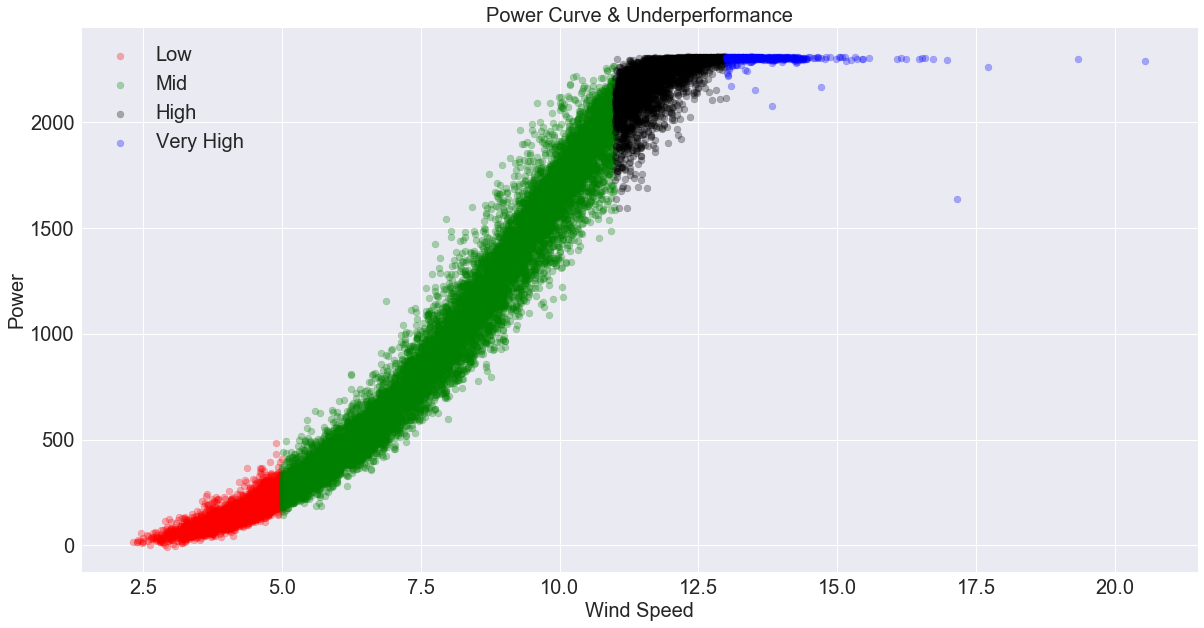

In [13]:
import matplotlib

x1 = df_clean_low['wtc_AcWindSp_mean']
y1 = df_clean_low['wtc_ActPower_mean'] 

x2 = df_clean_mid['wtc_AcWindSp_mean']
y2 = df_clean_mid['wtc_ActPower_mean']

x3 = df_clean_high['wtc_AcWindSp_mean']
y3 = df_clean_high['wtc_ActPower_mean']

x4 = df_clean_veryhigh['wtc_AcWindSp_mean']
y4 = df_clean_veryhigh['wtc_ActPower_mean']

# x4 = df_clean_toohigh['ExpectedEnergy_']
# y4 = df_clean_toohigh['wtc_ActPower_mean']

# c = df['Underperformance']
# labels = ['Blue = Underperformance']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.scatter(x1, y1,alpha=0.3, label='Low', c='r')
plt.scatter(x2, y2,alpha=0.3,label='Mid', c='g')
plt.scatter(x3, y3,alpha=0.3, label='High', c='k')
plt.scatter(x4, y4,alpha=0.3,label='Very High', c='b')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve & Underperformance")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend()
plt.show()

In [14]:
low_median = df_clean_low.groupby('WindSpeed_adj').median()
mid_median = df_clean_mid.groupby('WindSpeed_adj').median()
high_median = df_clean_high.groupby('WindSpeed_adj').median()
veryhigh_median = df_clean_veryhigh.groupby('WindSpeed_adj').median()

In [15]:
low_5th = df_clean_low.groupby('WindSpeed_adj').quantile(0.05)
mid_5th = df_clean_mid.groupby('WindSpeed_adj').quantile(0.05)
high_5th = df_clean_high.groupby('WindSpeed_adj').quantile(0.05)
veryhigh_5th = df_clean_veryhigh.groupby('WindSpeed_adj').quantile(0.05)

parameters: [ 170.55698872 -129.37315243   26.47639334]
stats: [array([ 660.47301958]), 3, array([ 1.70885711,  0.28197743,  0.01720814]), 6.2172489379008766e-15]


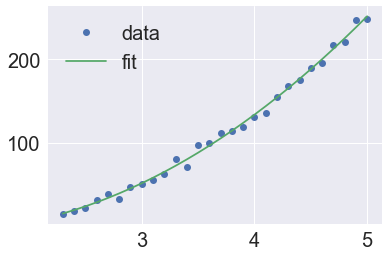

In [16]:
# low
from numpy.polynomial import polynomial as P
from numpy.polynomial.polynomial import polyval

degree = 2

# Median
xdata = low_median.index.values
ydata = low_median['wtc_ActPower_mean'].values

low_median_c, stats = P.polyfit(xdata, ydata,degree,full=True)

# 5th quantile
xdata2 = low_5th.index.values
ydata2 = low_5th['wtc_ActPower_mean'].values

low_5th_c, stats2 = P.polyfit(xdata2, ydata2,degree,full=True)

# mid25_k = popt[1]
# mid25_cap = cap
# print('x0:',mid25_x0)
# print('k:',mid25_k)
print('parameters:',low_5th_c)
print('stats:',stats)

y = polyval(xdata,low_median_c)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
# pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

parameters: [  7.55527841e+03  -5.42013205e+03   1.52383471e+03  -2.08913688e+02
   1.43321031e+01  -3.86949422e-01]
stats: [array([ 5077.99950908]), 6, array([  2.36911812e+00,   6.15684764e-01,   9.02619239e-02,
         8.01177777e-03,   4.58779767e-04,   1.55727811e-05]), 1.354472090042691e-14]


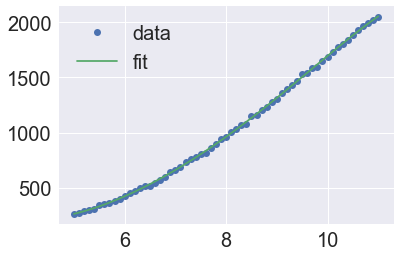

In [17]:
# mid
from numpy.polynomial import polynomial as P
from numpy.polynomial.polynomial import polyval

degree = 5

# Median
xdata = mid_median.index.values
ydata = mid_median['wtc_ActPower_mean'].values

mid_median_c, stats = P.polyfit(xdata, ydata,degree,full=True)

# 5th quantile
xdata2 = mid_5th.index.values
ydata2 = mid_5th['wtc_ActPower_mean'].values

mid_5th_c, stats2 = P.polyfit(xdata2, ydata2,degree,full=True)

# mid25_k = popt[1]
# mid25_cap = cap
# print('x0:',mid25_x0)
# print('k:',mid25_k)
print('parameters:',mid_5th_c)
print('stats:',stats)

y = polyval(xdata,mid_median_c)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
# pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

parameters: [ -5.61886324e+06   2.39080940e+06  -4.06688587e+05   3.45719808e+04
  -1.46826572e+03   2.49170181e+01]
stats: [array([ 428.8877672]), 6, array([  2.44094637e+00,   2.04292156e-01,   6.74510577e-03,
         1.30679354e-04,   1.60150285e-06,   1.14605135e-08]), 4.6629367034256575e-15]


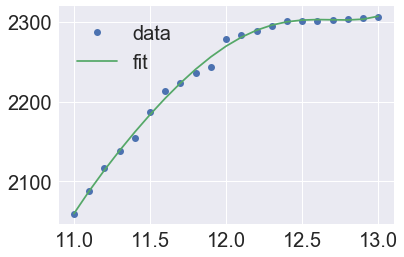

In [18]:
# high
from numpy.polynomial import polynomial as P
from numpy.polynomial.polynomial import polyval

degree = 5

# median
xdata = high_median.index.values
ydata = high_median['wtc_ActPower_mean'].values

high_median_c, stats = P.polyfit(xdata, ydata,degree,full=True)

# 5th quantile
xdata2 = high_5th.index.values
ydata2 = high_5th['wtc_ActPower_mean'].values

high_5th_c, stats2 = P.polyfit(xdata2, ydata2,degree,full=True)

# mid25_k = popt[1]
# mid25_cap = cap
# print('x0:',mid25_x0)
# print('k:',mid25_k)
print('parameters:',high_median_c)
print('stats:',stats)

y = polyval(xdata,high_median_c)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
# pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

parameters: [ 2503.78820821   -14.62290051]
stats: [array([ 410640.56393504]), 2, array([ 1.41206561,  0.07791476]), 8.2156503822261584e-15]


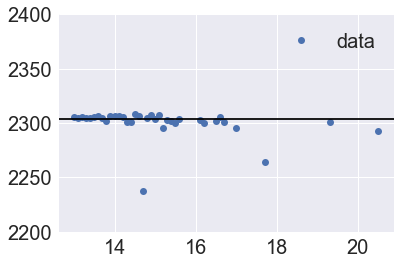

In [19]:
# Very High
from numpy.polynomial import polynomial as P
from numpy.polynomial.polynomial import polyval

xdata = veryhigh_median.index.values
ydata = veryhigh_median['wtc_ActPower_mean']

# cap = np.max(mid25['wtc_ActPower_mean'].values)

c, stats = P.polyfit(xdata, ydata,1,full=True)
veryhigh_c = c
# mid25_k = popt[1]
# mid25_cap = cap
# print('x0:',mid25_x0)
# print('k:',mid25_k)
print('parameters:',c)
print('stats:',stats)

x = xdata
y = polyval(x,c)

pylab.plot(xdata, ydata, 'o', label='data')
# pylab.plot(xdata,y, label='fit')
pylab.ylim(2200, 2400)
plt.axhline(y=np.median(ydata), color='k')
pylab.legend(loc='best')
pylab.show()

### Apply Curve Fitting Paramters to DataFrame

C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


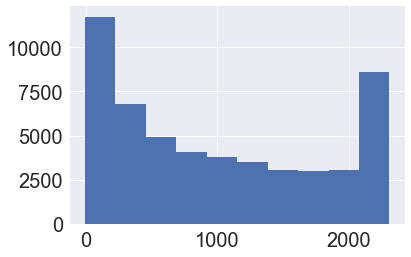

In [20]:
def ExpectedCalcMedian(wind):
    if wind <= low_thresh:
        y = polyval(wind,low_median_c)
        return y
    elif (wind > low_thresh) & (wind <= high_thresh):
        y = polyval(wind,mid_median_c)
        return y
    elif (wind > high_thresh) & (wind <= veryhigh_thresh):
        y = polyval(wind,high_median_c)
        return y
    else:
        y = veryhigh_median['wtc_ActPower_mean'].median()
        return y

def ExpectedCalc5th(wind):
    if wind <= low_thresh:
        y = polyval(wind,low_5th_c)
        return y
    elif (wind > low_thresh) & (wind <= high_thresh):
        y = polyval(wind,mid_5th_c)
        return y
    elif (wind > high_thresh) & (wind <= veryhigh_thresh):
        y = polyval(wind,high_5th_c)
        return y
    else:
        y = veryhigh_median['wtc_ActPower_mean'].median()
        return y
df_clean['ExpectedEnergy_median'] = df_clean['wtc_AcWindSp_mean'].map(ExpectedCalcMedian)
df_clean['ExpectedEnergy_5th'] = df_clean['wtc_AcWindSp_mean'].map(ExpectedCalc5th)
# df_clean['ExpectedEnergy'].hist()


df['ExpectedEnergy_median'] = df['wtc_AcWindSp_mean'].map(ExpectedCalcMedian)
df['ExpectedEnergy_5th'] = df['wtc_AcWindSp_mean'].map(ExpectedCalc5th)
df['ExpectedEnergy_median'].hist()

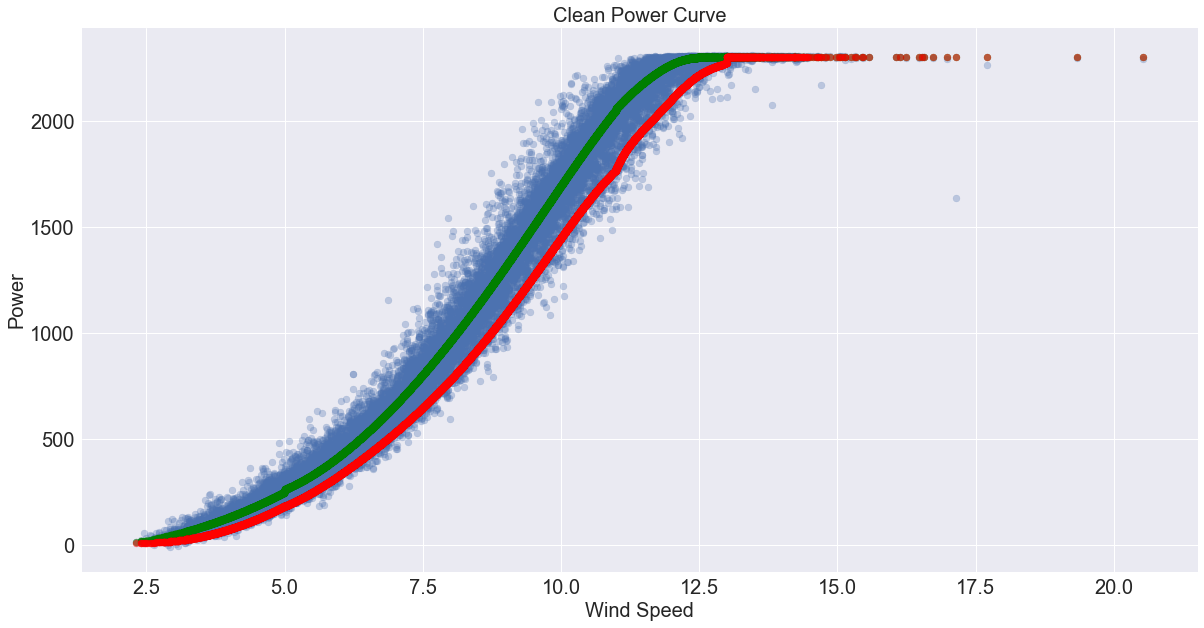

In [21]:
# Plot expected energy on clean data

x1 = df_clean['wtc_AcWindSp_mean']
y1 = df_clean['ExpectedEnergy_median'] 

x2 = df_clean['wtc_AcWindSp_mean']
y2 = df_clean['wtc_ActPower_mean'] 

x3 = df_clean['wtc_AcWindSp_mean']
y3 = df_clean['ExpectedEnergy_5th'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.scatter(x2, y2,alpha=0.3)#, c=c)
plt.scatter(x1,y1,alpha = 0.5, c='g')
plt.scatter(x3,y3,alpha = 0.5, c='r')

plt.title("Clean Power Curve")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
# plt.legend()
plt.show()

### Turbine Performance Classification
The goal of our SVM model is to predict if a wind turbine is performing in one of three ways: 

- minimum performance 
- average (or median performance) 
- maximum performance

We will achieve this analysis, first, through feature engineering.

#### Feature Engineering

We achieve feature engineering through class label creation. This is done by creating a simple function and applying it to the data frame.

In [22]:
# Make labels
# insipred by: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

def make_class(row):
    if row["wtc_ActPower_mean"] <= row["ExpectedEnergy_5th"]:
        return "1"
    else:
        return "0"

df["Underperformance"] = df.apply(lambda x: make_class(x), axis=1)
df['Underperformance'] = df['Underperformance'].astype(int)

percent = (df['Underperformance'].sum() / len(df))*100
print('Percent of Under Performance Data:',percent,"%")

Percent of Under Performance Data: 26.3386561988 %


<a id="Create Models"></a>
<a href="#top">Back to Top</a>
# Create Models

<b>[50 points]</b>

<i>
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate</b>. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 
</i>


### Regression Models

#### Polynomial Regression

In [23]:
y = df_clean["wtc_ActPower_mean"]

dropcols = ['wtc_ActPower_mean','Description', 'Name','WindSheer1','PowerDelta','wtc_ActPower_stddev']

X = df_clean.drop(dropcols, axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

class CappedLinearRegression(LinearRegression):
    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), y.min(), y.max()) 

### Grid Search
The parameters adjusted were the degree polynomial for the transformation, if the is to be normalized, and if the intercept is to be fit. This was done using a ten fold cross-validation with a 20/80 split for training and testing. The scoring parameter used is the R-squared.  

In [ ]:
from sklearn.model_selection import GridSearchCV

# Possible Parameters:
    # 'memory',
    #  'steps',
    #  'poly',
    #  'linear',
    #  'poly__degree',
    #  'poly__include_bias',
    #  'poly__interaction_only',
    #  'linear__copy_X',
    #  'linear__fit_intercept',
    #  'linear__n_jobs',
    #  'linear__normalize'

parameters = {'poly__degree':[2,3],'linear__normalize':(True,False), 'linear__fit_intercept':(True,False)}

model = Pipeline([('poly', PolynomialFeatures()),
                      ('linear', CappedLinearRegression())])

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3 #high number gives more description
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1 # all CPUs
                   , scoring='r2')

#Perform hyperparameter search to find the best combination of parameters for our data
# regGridSearch.fit(X, y) #UNCOMMENT TO RUN 

Fitting 3 folds for each of 2 candidates, totalling 6 fits


The best parameters shows the two degree polynomial was the best fit. 

In [29]:
# Execute model with best parameters from Grid Search

from sklearn.model_selection import cross_val_score

model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
                  ('linear', CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))])
model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=cv,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  0.990064169428


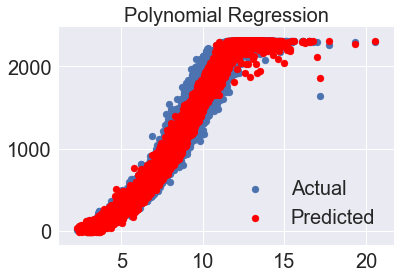

In [30]:
plt.scatter(x=X["wtc_AcWindSp_mean"], y=y, label='Actual')
plt.scatter(x=X["wtc_AcWindSp_mean"], y=y_hat, c='r', label='Predicted')
plt.axis('tight')
plt.legend()
plt.title("Polynomial Regression")
plt.show()

In [33]:
df_clean['ExpectedEnergy_polyreg'] = model.predict(X)

df_clean['residual_polyreg']= df_clean['wtc_ActPower_mean'] - df_clean['ExpectedEnergy_polyreg']

# df_clean['residual_polyreg'].hist()

C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Lasso Regression

In [27]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

model = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='r2')

regGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [35]:
# Execute model with best parameters from Grid Search
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

model = Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  0.963065209304


## Ridge Regression

In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='r2')

regGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   47.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [36]:
# Execute model with best parameters from Grid Search
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

model = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  0.952737869926


## ElasticNet Regression

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

model = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='r2')

regGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   36.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [37]:
# Executefrom sklearn.linear_model 
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

model = ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='r2')
print('Max R-squared: ',acc.max())

Max R-squared:  -0.0170456144688


# Classification

### Preprocessing

According to several references,  the SVM classifer benefits greatly from data scaling. Specifically, it can speed up the training process significantly. SciKitLearn has some built in functions to expedite this processs. First, however, before this process can begin, the variables must be encoded from the string class variable into a numeric variable that can be interpreted by SciKitLearn.

In [41]:
#Encode the labels (examples found on SKLearn website... need to find address)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
df["target"] = le.transform(df["Underperformance"])


#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]

# keepcols = ['BoostedRef', 'WindSheer1',
#             'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
#             'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
#            'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

# data = df[keepcols]

dropcols = ['wtc_ActPower_mean','Description', 'Name','WindSheer1','PowerDelta','wtc_ActPower_stddev','Underperformance',
            'target', 'StationId', 'ExpectedEnergy_5th', 'ExpectedEnergy_median', 'wtc_PowerRef_endvalue', 'WindSpeed_adj']

X = df.drop(dropcols, axis=1)

# X = preprocessing.scale(data) 

# data.columns

#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

# parameters:
    # 'bootstrap',
    #  'class_weight',
    #  'criterion',
    #  'max_depth',
    #  'max_features',
    #  'max_leaf_nodes',
    #  'min_impurity_decrease',
    #  'min_impurity_split',
    #  'min_samples_leaf',
    #  'min_samples_split',
    #  'min_weight_fraction_leaf',
    #  'n_estimators',
    #  'n_jobs',
    #  'oob_score',
    #  'random_state',
    #  'verbose',
    #  'warm_start']

parameters = {'n_estimators': [200, 700], 'max_features': ['auto', 'sqrt', 'log2']}

model = RandomForestClassifier() 


regGridSearch = GridSearchCV(estimator=model
                   , verbose=3
                   , param_grid=parameters
                   , cv=cv
                   , n_jobs=-1
                   , scoring='accuracy')

# regGridSearch.fit(X, y) # Uncomment to run 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 700], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [42]:
# Execute model with best parameters from Grid Search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

model.fit(X, y)
y_hat = model.predict(X)

acc = cross_val_score(model, X, y, cv=3,scoring='accuracy')
print('Max Accuracy: ',acc.max())

Max Accuracy:  0.926137662932


In [49]:
model.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=733631411, splitter='best')

In [57]:
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(model.estimators_[0], 
                     out_file=dot_data, 
                     feature_names=X.columns,  
#                      class_names=y.unique(),
#                     filled=True,
#                     rounded=True,
#                     impurity=False
                    )

graph = pydot.graph_from_dot_data(dot_data.getvalue())
# graph.
# graph.write_pdf('underperformance.pdf')
# graph = pydot.Dot(graph_type='graph')
# graph2 = pydot.Graph(graph)
Image(graph.create_png())

AttributeError: 'list' object has no attribute 'create_png'

In [38]:
# Plot shows features and their weights

weights = pd.Series(model.feature_importances_,index=X.columns)
weights.sort_values(inplace=True)

plt.figure(figsize=(10, 20))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

weights.plot(kind='barh')

plt.title("Random Forest Feature Weights")
plt.xlabel('Weight')
plt.ylabel('Features')
#plt.legend()
plt.show()

AttributeError: 'ElasticNet' object has no attribute 'feature_importances_'

## Support Vector Machine (SVM) Model

### Model Creation and Parameter Optimization With Grid Search

Running the SVC classifier within SciKit Learn proved to be to costly computationally. As a result, we proceeded with a differnt SVM Classifier. Specifically, we use the SGDClassifier which utilized stochastic gradient descent and greatly increased training rates.

Since there are many possible parameters that can be put into the classifer, we ran through various alphas (or a penalty term), learning rates, and learning rate schedules to find the strongest possible model based on the input parameters. This was done using a grid search.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

## Results
The best SGDClassifer had the following attributes: 'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal'

The resulting model had an accuracy of 86.78 percent. 

In [21]:
# Thanks to sklearn for a great example: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn import linear_model

# Set the parameters by cross-validation
clist = [0.1, 1, 10, 100]
tuned_parameters = [#{'kernel': ['rbf'], 'C': clist},
                    {'kernel': ['linear'], 'C': clist}
#                     {'kernel': ['poly'], 'C': clist},
#                     {'kernel': ['sigmoid'], 'C': clist}
                   ]

alphas = 10.0**-np.arange(1,7)
tp = [{'alpha':alphas, 'learning_rate':['constant', 'optimal', 'invscaling'], 'eta0': [0.01, 0.1, 0.5, 1.0]}]

# clf = GridSearchCV(svm.SVC(), tuned_parameters)
clf = GridSearchCV(linear_model.SGDClassifier(), tp)
# clf = svm.SVC(kernel='linear', C=1
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
# print("The model is trained on the full development set.")
# print("The scores are computed on the full evaluation set.")
# print()
y_true, y_pred = y_test, clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(classification_report(y_true, y_pred))
print()
print("Accuracy:", acc)

Best parameters set found on development set:

{'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal'}

Grid scores on development set:

0.861 (+/-0.008) for {'alpha': 0.10000000000000001, 'eta0': 0.01, 'learning_rate': 'constant'}
0.861 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.01, 'learning_rate': 'optimal'}
0.861 (+/-0.008) for {'alpha': 0.10000000000000001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
0.829 (+/-0.098) for {'alpha': 0.10000000000000001, 'eta0': 0.1, 'learning_rate': 'constant'}
0.861 (+/-0.008) for {'alpha': 0.10000000000000001, 'eta0': 0.1, 'learning_rate': 'optimal'}
0.861 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.1, 'learning_rate': 'invscaling'}
0.820 (+/-0.065) for {'alpha': 0.10000000000000001, 'eta0': 0.5, 'learning_rate': 'constant'}
0.861 (+/-0.008) for {'alpha': 0.10000000000000001, 'eta0': 0.5, 'learning_rate': 'optimal'}
0.861 (+/-0.008) for {'alpha': 0.10000000000000001, 'eta0': 0.5, 'learning_rate': 'invscaling'}
0.738 (+

## Interpret Support Vectors
<b>[10 points]</b>

<i>
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.
</i>

### Chosen Support Vector Investigation


Investigation of the support vectors tells us about the hyperplane used to separate the data. Specifically, it shows us which vectors define placement of classes. This knowledge is especially useful when classifying edge cases (i.e., where outlier data may be present) in which items could be misclassified.

However, if we fit a smaller model, using the SVC classifier, to apprehend what the support vectors might be, then, even using this smaller subset of data, the resulting array has a length of 5,584. This much information is not helpful or usable by our team to better understand the model. There are simply too many dimensions involved. This demonstrates the power of SVMs as a classifier, as they can handle high dimensional data and make accuarte predicitons with them where humans would fail or cannot even fathom the problem.

In [22]:
#First I want to create a new model object based on the results of the Grid Search
svm_class = svm.SVC(C=0.1, kernel='linear', gamma='auto')
# svm_class = linear_model.SGDClassifier(alpha= 1e-06, eta0= 0.5, learning_rate= 'invscaling')
svm_class.fit(X_train,y_train)

sv = svm_class.support_vectors_
print("There are " + str(len(sv)) + " support vectors")
for x in sv:
    print(x)
    


There are 2872 support vectors
[ -0.07492406   4.8014413    0.55869749   0.79922086   0.23166755
   0.02660211  -0.59556133  -0.61746188   1.03826014  -1.33961537
  13.3041347    1.42185824]
[-2.53918953 -0.88216214 -1.55046855  0.05604598 -0.46436633 -0.81358094
 -0.64085709 -0.71915284 -0.28782118  0.6981037  -0.0751646  -0.68399346]
[ 0.76006153  2.49771484  0.92774184  0.33711161  0.23166755  0.45021068
  0.2142071   0.42276036  0.15420593 -1.10507529 -0.0751646   0.99615274]
[-1.17521696 -0.65975147  0.28124463  0.26700526  0.23166755  0.57135335
  0.84792034  0.68402174 -0.14047881  0.94660602 -0.0751646  -0.85686542]
[ 0.76006153  0.38805339  1.53239168 -0.079043    0.23166755  0.71985082
  0.47444403  0.69206056 -0.43516355  1.30142635 -0.0751646  -1.21038552]
[-1.40308827 -0.96973556 -1.70312765 -0.96812658 -1.30469993 -1.50722044
 -1.43054156 -1.4000402   0.44889067 -0.17934008 -0.0751646   0.23170439]
[-1.88324568  1.63048258 -1.02417106 -1.59026639  0.23166755 -0.58809926
 

  1.27951196  1.35928193 -0.28782118  0.69041806 -0.0751646  -0.6775959 ]
[ 0.94724154  0.34870607  2.43573624  0.01283447  0.23166755  1.3411955
  1.21114101  1.30702965  0.15420593  0.35481183 -0.0751646  -0.29636271]
[ 0.51754135 -0.52115412  0.49715549  0.22063301  0.23166755  1.15361975
  1.48035163  1.24673857 -1.17187539  1.71901274 -0.0751646  -1.70252664]
[-1.66188498 -0.86716219 -0.10272933 -1.86941314  0.23166755 -0.45132528
 -0.31652239 -0.44261772  0.44889067  0.00639619 -0.0751646   0.06957246]
[-1.43075836 -0.38500686  0.07331603  1.5779386   0.23166755  1.21223717
  1.49744437  1.32310728  0.00686356 -1.16886609 -0.0751646   1.0205403 ]
[-2.18598899  1.73039757 -1.05164357  0.83909993  0.23166755 -0.29579372
 -0.17208876 -0.24446101  1.18560251 -1.93576477 -0.0751646   2.02707194]
[-2.36014778  0.19072631 -1.0661611  -1.8385735   0.23166755 -1.03789028
 -0.97459279 -1.015785    1.03826014 -1.75604891 -0.0751646   1.81793061]
[-1.6032895  -0.18110646 -0.21499496  0.15478

  0.51632124  0.57951719  0.44889067 -1.2964477  -0.0751646   1.24277692]
[ 0.76006153 -0.85783346  1.68191062 -1.74125347  0.23166755 -1.92731197
 -1.85657804 -1.92859207  0.3015483   0.6788896  -0.0751646  -0.53676817]
[-1.29566323 -0.60248508 -1.45534108 -0.47655437 -0.31157841 -1.97068886
 -1.87110686 -1.86307575  1.48028725 -0.3343338  -0.0751646   0.60432304]
[-1.90277751  1.09498617 -1.04370406 -0.7842647   0.23166755 -0.91674761
 -0.62974681 -0.82606904  1.92231436 -1.15349482 -0.0751646   1.45484262]
[-2.66289109 -1.50359065 -1.27601679 -1.69236334  0.23166755 -0.9624692
 -0.38959385 -0.77864005  1.03826014 -1.14721821 -0.0751646   1.24200598]
[ 0.76006153  0.3378622   1.49774815 -0.00630799  0.23166755  1.1340806
  0.96329632  1.13821461 -0.43516355  1.07470001 -0.0751646  -1.02674326]
[ 0.94724154  1.22172279  1.97864273  0.1533853   0.23166755  0.7589291
  0.47572599  0.71617699 -0.58250592 -0.20111606 -0.0751646   0.01563081]
[ 0.94724154 -0.64325286  2.0752858   0.2468420

  0.07703789  0.28368892 -1.31921776 -0.01537978 -0.0751646  -0.31264354]
[-1.06453661  1.73633458  0.66592718  0.11558477  0.23166755  0.47365765
  0.10438627  0.41070215 -1.31921776 -0.1639688  -0.0751646  -0.18454908]
[-0.90990965 -0.5782291   1.60426745 -0.34818222  0.23166755  1.13017278
  1.26241923  1.18644748 -1.76124487  1.49100545 -0.0751646  -1.6512368 ]
[ 0.519169   -0.44162734  1.88888983 -0.00672667  0.23166755  2.03288108
  2.29225666  2.13502726 -0.72984829  0.81979298 -0.0751646  -0.88298819]
[ 0.76006153  1.61263205  0.44872558 -0.54983736  0.23166755 -0.01716557
 -0.25327927 -0.06680327  2.06965673 -1.27556838 -0.0751646   1.60410349]
[ 0.37756326  1.04103061  0.85000536 -0.1486957   0.23166755  0.42676371
  0.25095649  0.43481858  0.89091778  0.8428499  -0.0751646  -0.54268573]
[ 0.40035039 -1.95415075  0.16411675 -1.12398767  0.23166755 -1.77178041
 -1.22158284 -1.59538332  1.03826014 -1.62974824 -0.0751646   1.69681019]
[-1.39983297  1.01357892  0.02314055  1.3630

## Logistic Regression

For the Logistics Regression model, we begin by further sizing down our dataset. 

Next, we use scikit-learn to perform logistic regression on our testing and training sets in order to determine which variables impact our response variable. 
We created a function using x_train and y_train from our dataset to test for x_test.  
The accuracy of the regression prediction was compared with that of that original. 
A confustion matrix was produced to reflect an accuracy percentage, demonstrating almost 90%!

In [23]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
df["target"] = le.transform(df["Underperformance"])

#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]

keepcols = ['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density']
df3 = df[keepcols]
X = preprocessing.scale(df3) 

In [24]:
#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_clf = LogisticRegression(C=1.0, class_weight=None)

from sklearn.model_selection import ShuffleSplit
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)      

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
   
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)   

====Iteration 0  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 1  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 2  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 3  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 4  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 5  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 6  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 7  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 8  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 9  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
[ 0.88884555  0.89586583  0.8798752   0.88728549  0.88533541  0.88572543
  0.87948518  0.8

<a id="Feature Importances"></a>
<a href="#top">Back to Top</a>
## Feature Importance

<b>[30 points]</b>

<i>
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</i>

Next, we applied weights to each feature to determine the importance of each attribute as it pertains to predicting turbine performance.  

A detailed list of the features and their weights are listed below.  We will discuss them in greater detail, along with a visualization in the next section.

In [25]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df3.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

BoostedRef has weight of -0.971551954442
WindSheer1 has weight of 0.831580718782
wtc_AcWindSp_mean has weight of 1.41899311134
wtc_NacelPos_mean has weight of -0.349011041266
wtc_ScInOper_timeon has weight of -2.61643050384
WS_Thies_80m_Avg has weight of -1.68657011775
WS_Thies_60m_Avg has weight of 2.45846113455
WS_ICEFREE_Avg has weight of -0.707164686277
BP_mbar_76m_Avg has weight of -0.871161641589
AirTC_3m_Avg has weight of 3.01695863176
Icing has weight of -0.147021100074
Air_density has weight of 3.18684988864


### Power Curve Variations
Given the figure below, the feature weights make a lot of sense in predicting turbine performance. 
1. Air Density (Air_Denisty)
    * Air density determines how much force a given volume of air will exert on the turbine blades. 
2. Air Temperature (AirTC_3m_Avg)
    * This feature can correlate with other weather events such as turbulence and storms.
3. Wind Speed (WS_Thies_60m_Avg, wtc_AcWindSp_mean, WS_Thies_80m_Avg)
    * Obviously this is an important factor in determining proper performance.
4. Barometric Pressure (BP_mbar_76m_Avg)
    * This is another feature that can correlate with storms and other weather.
5. Boosted Reference Set Point (BoostedRef)
    * This is an important factor since low turbine performance may be due to a commanded reduction in set point by the electrical grid. Without this factor, there could be a lot of false positives. This feature also has the boosted value incorporated into it to account for times when the turbine is allowed to exceed its nameplate capacity.
6. In-Operation Time (wtc_ScInOper_timeon)
    * This feature is similar to the reference set point in that we would see more false positives without this feature. When a turbine is faulted, it is shut down. This counter gives the amount of seconds in the ten minute window the turbine was running. 
7. Features Removed
    * There were many columns that were thought to be important that did not have large weights in the model. These include: YawError and turbulence.

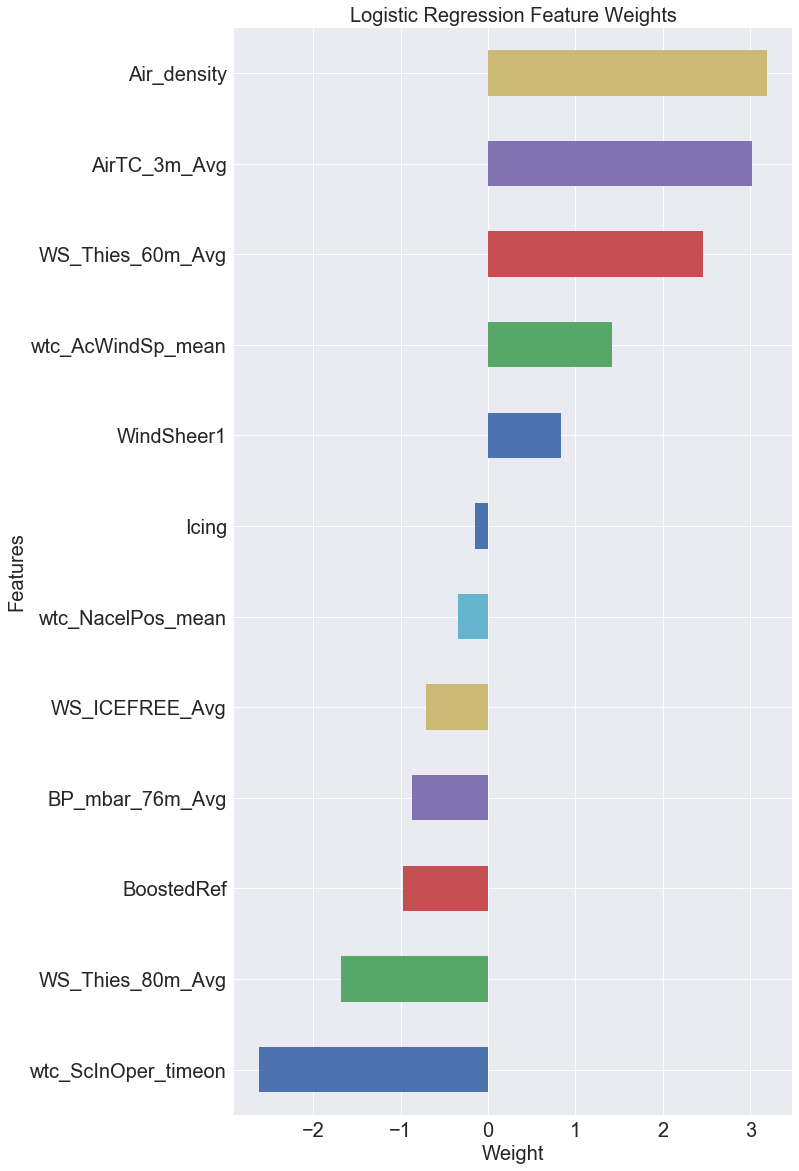

In [27]:
# Plot shows features and their weights

weights = pd.Series(lr_clf.coef_[0],index=df3.columns)
weights.sort_values(inplace=True)

plt.figure(figsize=(10, 20))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

weights.plot(kind='barh')

plt.title("Logistic Regression Feature Weights")
plt.xlabel('Weight')
plt.ylabel('Features')
#plt.legend()
plt.show()

<a id="Model Advantages"></a>
<a href="#top">Back to Top</a>
## Model Advantages

<b>[10 points]</b>

<i>
Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
</i>

By comparison of accuracy, there was little difference between SVM and logistic regression with accuracies of 87% and 89%, respectively. As the accuracy is so similar, we ultimatley believe that logistic regression is the best method for our dataset, as with compared to SVM with gradient based optimization (SGD). Because our accuracies were so similar, the primary reason for this decision was model interpretability and processing speed if applied at scale.

A key factor in choosing the logistic model was that we could easily explain the weights of the logstic model to stake holders (or anyone else that was interested in the model). In theory, we could use the decision boundry from the SVM model to explain how classes were categorized. However, our decision space was quite large an interpresting the support vectors was difficult. Since both models preformed at similar levels, we opeted for the model that we could easily explain to others.

Another deciding factor was the amount of time it took to train the models. The non SGD SVM took a significant amount of time to train our model, especially when using cross validation. This processing time was decreased dramatically by using stochasitc gradient descent. For example, SGD, SVM ran for an hour without producing any results.  With SGD, we had results within minutes. In fact, we were not able to fully train a SVM model on our computers without SGD, let alone compare many different models.  However, even wiht gradient optimization, logistic regression was still the most efficient option.  And, we've noted that our analysis would be most effective is trained at least 12 months of data, in order to capture all possible environmental conditions. Given that one quarter of data (our current dataset) contains 1,048,576 observations, going forward its essential that we have the most efficient process possible, as our dataset will be exponentially larger.

While, we do believe that logistics regression serves our current dataset best, we did recognize a few key advantages to SVM.  We noted that SVM can be altered to support several different classes, while logistics regression can only fit two.  In addition, SVM can support non-lineral data and robust to outliers.  Finally, SVM has more options for controlling model output (i.e. kernel, penalty terms (C), gamma) which can allow a log of flexability in the modelling process.  We did not note the same benefit for logistic regression.

### Conclusion
In the end we were able to properly classify almost 90% of the underperformance occurances for this turbine (shown in the scatter plot below).  The variables related to air density, air temperature, wind speed, barometric pressure, boosted reference set point, and in-operation time were important in predicting performance.  As four of those variables are specifically releated to weather, we note that future analysis should include at least 12 months of observations, rather than the one quarter we currently analyzed, as weather is a critical variable in turbine performance which has a seasonal component.

### Deployment
These models are very important to the company to find turbines that are underperforming. There are so many factors that affect turbine performance that the analysis is very difficult to do with traditional techniques. The best way to estimate the model value would be to calculate the cost savings of flagging turbines that need to be fixed. There is potentially a lot of money being wasted by not running the assets at their full potential. I would deploy the model as a residual time series after training the model on the first year of operation. This will capture the turbines presitine state and be able to show drifts downward due to gradual blade erosion. A threshold can be set to trigger an alarm after so many points beyond the threshold. The data presented in this report is being collected on a real time basis so no large changes in how data is collected is needed to take this model to production. 